In [ ]:
import pandas as pd
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Flatten, BatchNormalization
from keras.layers import Bidirectional, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from keras import regularizers
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, EarlyStopping


class EpilepsyClassifier:
    def __init__(self, path, seed=42, timesteps=128):
        self.data_dim = 0
        self.df = pd.read_csv(path, index_col=0)
        self.df_best = pd.DataFrame(columns=['seed', 'Timestep', 'Acc', 'Val_acc', 'Loss', 'Val_loss'])
        self.timesteps = timesteps
        self.seed = seed
        self.categorize_y()
        self.shuffle_rows()
        self.shape_data()
        self.x_train = pd.DataFrame()
        self.x_test = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.split_()
        self.model_()
        self.return_results()

    # Previous methods remain the same until model_()
    def categorize_y(self):
        self.df['y'] = self.df['y'].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

    def shuffle_rows(self):
        self.df = self.df.sample(frac=1, random_state=self.seed)

    def shape_data(self):
        data_length = 4096
        timesteps = self.timesteps
        self.data_dim = data_length // timesteps
        print('data dimension: ', self.data_dim)
        print('timesteps: ', self.timesteps)

    def split_(self):
        X = self.df.drop(['y'], axis=1)
        y = self.df['y']

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y,
                                                                               random_state=self.seed,
                                                                               stratify=y,  # Added stratification
                                                                               test_size=0.2)

        # Reshape data
        self.x_train = np.reshape(self.x_train.values, (self.x_train.shape[0], self.timesteps, self.data_dim))
        self.x_test = np.reshape(self.x_test.values, (self.x_test.shape[0], self.timesteps, self.data_dim))

        # Normalize the data
        mean = np.mean(self.x_train)
        std = np.std(self.x_train)
        self.x_train = (self.x_train - mean) / std
        self.x_test = (self.x_test - mean) / std

    def model_(self):
        # Setup callbacks
        csv_logger = CSVLogger('LSTM_Model_Logger.log')
        checkpoint = ModelCheckpoint('best_model.keras',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.2,
                                     patience=5,
                                     min_lr=1e-6)
        early_stopping = EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     restore_best_weights=True)

        tf.random.set_seed(self.seed)

        model = Sequential([
            # 1D CNN layers for feature extraction
            Conv1D(filters=64, kernel_size=3, padding='same',
                  input_shape=(self.timesteps, self.data_dim)),
            BatchNormalization(),
            Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.4),

            # Bidirectional LSTM layers
            Bidirectional(LSTM(128, return_sequences=True,
                             recurrent_regularizer=l2(0.01))),
            BatchNormalization(),
            Dropout(0.4),

            Bidirectional(LSTM(64, return_sequences=True,
                             recurrent_regularizer=l2(0.01))),
            BatchNormalization(),
            Dropout(0.4),

            # Dense layers for classification
            TimeDistributed(Dense(32, activation='relu',
                                kernel_regularizer=l2(0.01))),
            BatchNormalization(),
            GlobalAveragePooling1D(),
            Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.3),
            Dense(5, activation='softmax')
        ])

        # Compile with custom learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
        model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])

        print(model.summary())

        # Train with callbacks
        history = model.fit(self.x_train, self.y_train,
                          validation_data=(self.x_test, self.y_test),
                          callbacks=[csv_logger, checkpoint, reduce_lr, early_stopping],
                          batch_size=32,  # Reduced batch size
                          epochs=100)  # Increased epochs with early stopping

        # Rest of the plotting and evaluation code remains the same
        best_val = history.history['val_accuracy'][-1]
        best_acc = history.history['accuracy'][-1]
        best_loss = history.history['loss'][-1]
        best_val_loss = history.history['val_loss'][-1]

        df_ = pd.DataFrame()
        df_.loc[self.seed, 'seed'] = self.seed
        df_.loc[self.seed, 'Timestep'] = self.timesteps
        df_.loc[self.seed, 'Acc'] = best_acc
        df_.loc[self.seed, 'Val_acc'] = best_val
        df_.loc[self.seed, 'Loss'] = best_loss
        df_.loc[self.seed, 'Val_loss'] = best_val_loss

        self.df_best = pd.concat([self.df_best, df_], ignore_index=True)

        # Plotting code remains the same
        self._plot_training_history(history)
        self._plot_confusion_matrix(model)

    def _plot_training_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def _plot_confusion_matrix(self, model):
        y_pred = model.predict(self.x_test)
        y_pred_class = np.argmax(y_pred, axis=1)

        target_names = ['0', '1', '2', '3', '4']
        print(classification_report(self.y_test, y_pred_class, target_names=target_names))

        cm = confusion_matrix(self.y_test, y_pred_class)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='magma')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix Epileptic Seizures')
        plt.show()

    def return_results(self):
        return self.df_best

data dimension:  32
timesteps:  128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 128, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 64, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 64, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 64, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 465,605 (1.78 MB)

 Trainable params: 464,389 (1.77 MB)

 Non-trainable params: 1,216 (4.75 KB)

None
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.3515 - loss: 4.9530 - val_accuracy: 0.2600 - val_loss: 3.0233 - learning_rate: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5631 - loss: 2.2207 - val_accuracy: 0.2700 - val_loss: 2.3428 - learning_rate: 0.0050
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6521 - loss: 1.6581 - val_accuracy: 0.4100 - val_loss: 1.7356 - learning_rate: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6706 - loss: 1.2316 - val_accuracy: 0.2700 - val_loss: 2.1039 - learning_rate: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6959 - loss: 1.0032 - val_accuracy: 0.5800 - val_loss: 1.2637 - learning_rate: 0.0050
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7128 - loss: 0.9991 - val_accuracy: 0.3200 - val_loss: 1.7906 - learning_rate: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7542 - loss: 0.

<ipython-input-3-54d4bb09e0b7>:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_best = pd.concat([self.df_best, df_], ignore_index=True)


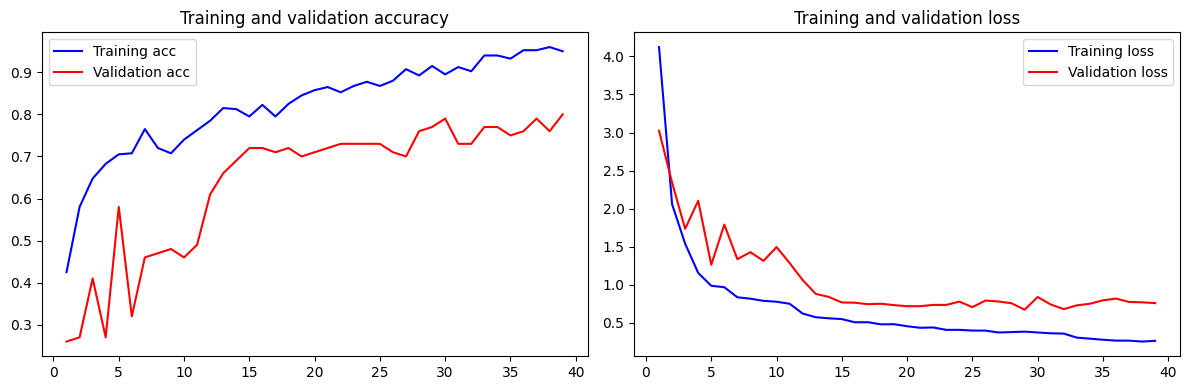

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.56      0.75      0.64        20
           2       0.73      0.55      0.63        20
           3       0.94      0.85      0.89        20
           4       0.73      0.80      0.76        20

    accuracy                           0.77       100
   macro avg       0.79      0.77      0.77       100
weighted avg       0.79      0.77      0.77       100



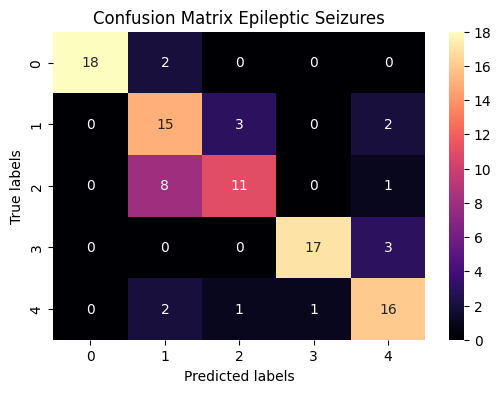

<ipython-input-4-1c363540345b>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Time_df = pd.concat([Time_df, classifier.return_results()], ignore_index=True)


data dimension:  32
timesteps:  128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 128, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 64, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 64, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 64, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 64, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_6           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 465,605 (1.78 MB)

 Trainable params: 464,389 (1.77 MB)

 Non-trainable params: 1,216 (4.75 KB)

None
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.3729 - loss: 4.8029 - val_accuracy: 0.2200 - val_loss: 2.9765 - learning_rate: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5277 - loss: 2.1879 - val_accuracy: 0.2300 - val_loss: 2.4940 - learning_rate: 0.0050
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6199 - loss: 1.6115 - val_accuracy: 0.2500 - val_loss: 2.5439 - learning_rate: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6536 - loss: 1.1910 - val_accuracy: 0.2500 - val_loss: 2.3011 - learning_rate: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6726 - loss: 1.0307 - val_accuracy: 0.4100 - val_loss: 1.4801 - learning_rate: 0.0050
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6698 - loss: 0.9653 - val_accuracy: 0.4400 - val_loss: 1.3908 - learning_rate: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6760 - loss: 0.

<ipython-input-3-54d4bb09e0b7>:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_best = pd.concat([self.df_best, df_], ignore_index=True)


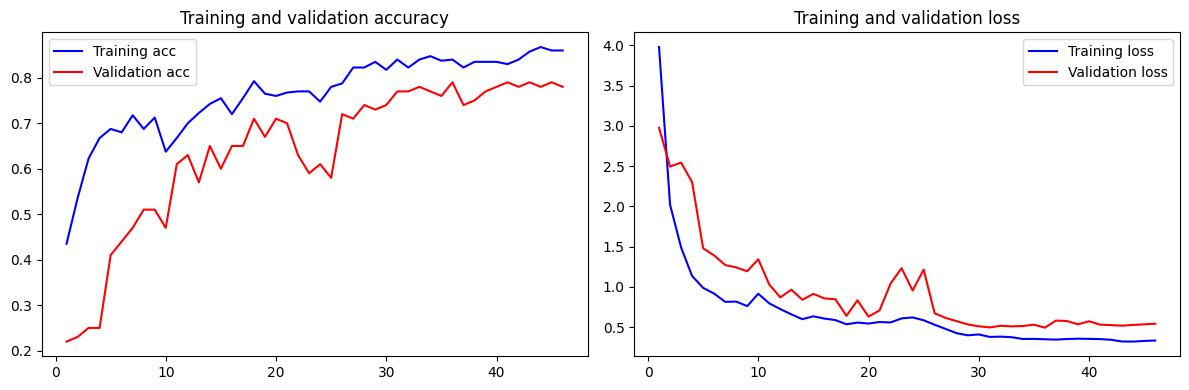

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.67      0.20      0.31        20
           2       0.54      0.95      0.69        20
           3       1.00      0.85      0.92        20
           4       0.87      1.00      0.93        20

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.76       100
weighted avg       0.82      0.79      0.76       100



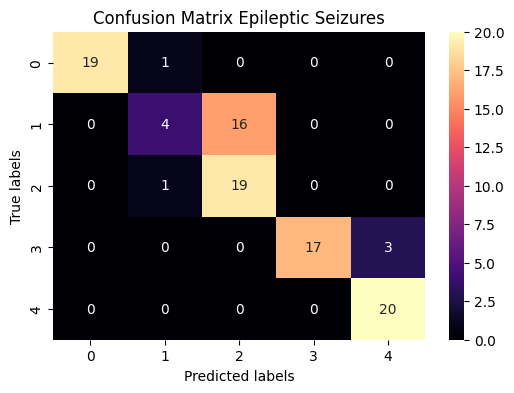

data dimension:  32
timesteps:  128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 128, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 64, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 64, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 64, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 64, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 465,605 (1.78 MB)

 Trainable params: 464,389 (1.77 MB)

 Non-trainable params: 1,216 (4.75 KB)

None
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.3285 - loss: 5.0984 - val_accuracy: 0.2000 - val_loss: 3.2827 - learning_rate: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4685 - loss: 2.5425 - val_accuracy: 0.2100 - val_loss: 2.6572 - learning_rate: 0.0050
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6260 - loss: 1.7346 - val_accuracy: 0.2600 - val_loss: 2.1956 - learning_rate: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5704 - loss: 1.5493 - val_accuracy: 0.2900 - val_loss: 1.9802 - learning_rate: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6502 - loss: 1.1872 - val_accuracy: 0.3500 - val_loss: 1.5774 - learning_rate: 0.0050
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6873 - loss: 1.0569 - val_accuracy: 0.4800 - val_loss: 1.4464 - learning_rate: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6624 - loss: 0.9

<ipython-input-3-54d4bb09e0b7>:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_best = pd.concat([self.df_best, df_], ignore_index=True)


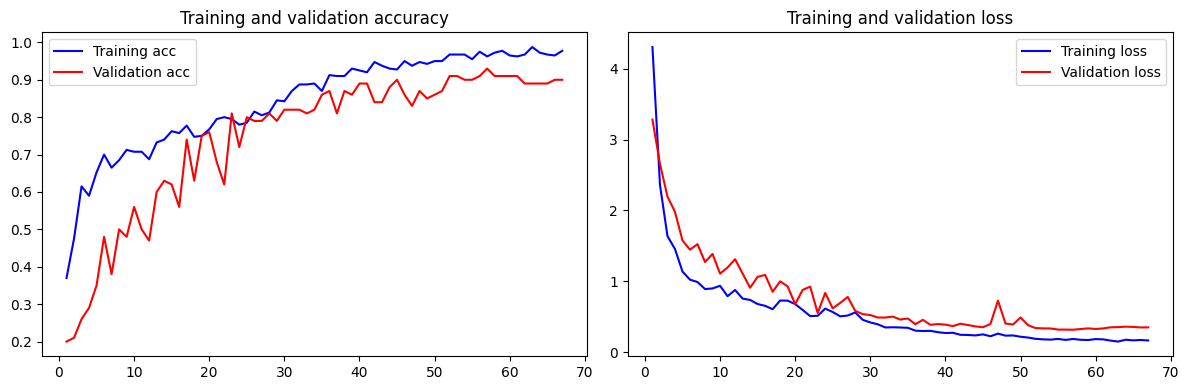

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.89      0.80      0.84        20
           2       0.82      0.90      0.86        20
           3       1.00      1.00      1.00        20
           4       1.00      0.95      0.97        20

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



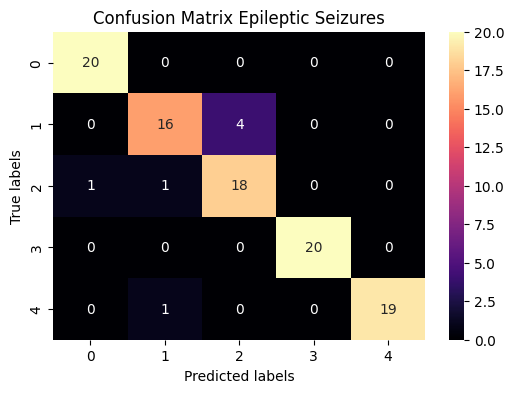

data dimension:  32
timesteps:  128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 128, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 64, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 64, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 64, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 64, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 465,605 (1.78 MB)

 Trainable params: 464,389 (1.77 MB)

 Non-trainable params: 1,216 (4.75 KB)

None
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.2927 - loss: 5.1259 - val_accuracy: 0.2000 - val_loss: 3.1141 - learning_rate: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4272 - loss: 2.5836 - val_accuracy: 0.2600 - val_loss: 2.3550 - learning_rate: 0.0050
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5926 - loss: 1.7698 - val_accuracy: 0.3600 - val_loss: 1.9854 - learning_rate: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6350 - loss: 1.4598 - val_accuracy: 0.3500 - val_loss: 1.9758 - learning_rate: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6503 - loss: 1.2435 - val_accuracy: 0.3200 - val_loss: 1.8858 - learning_rate: 0.0050
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6074 - loss: 1.2156 - val_accuracy: 0.4400 - val_loss: 1.5878 - learning_rate: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6664 - loss: 1.

<ipython-input-3-54d4bb09e0b7>:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_best = pd.concat([self.df_best, df_], ignore_index=True)


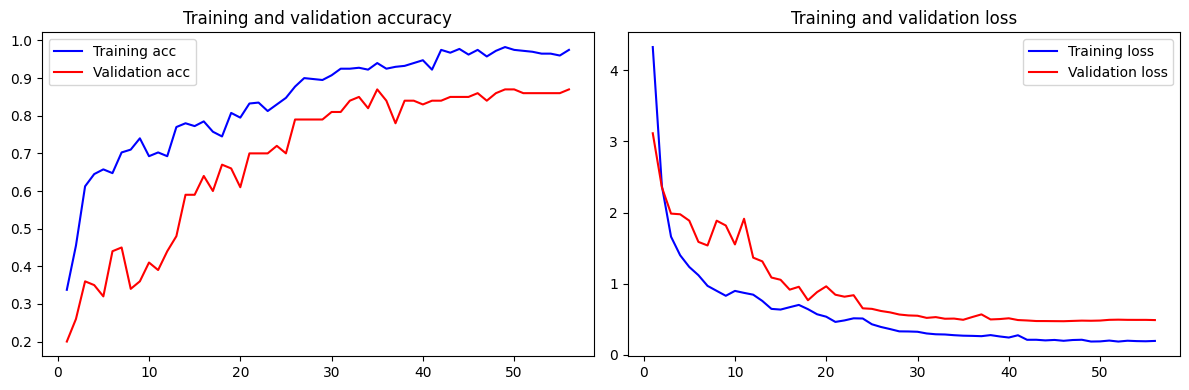

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.76      0.80      0.78        20
           2       0.78      0.70      0.74        20
           3       0.94      0.85      0.89        20
           4       0.83      0.95      0.88        20

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



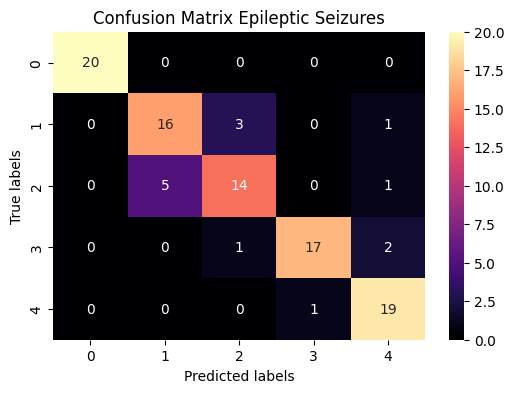

data dimension:  32
timesteps:  128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 128, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 64, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 64, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 64, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 64, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_9           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 465,605 (1.78 MB)

 Trainable params: 464,389 (1.77 MB)

 Non-trainable params: 1,216 (4.75 KB)

None
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.3722 - loss: 4.9999 - val_accuracy: 0.2000 - val_loss: 3.9127 - learning_rate: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4761 - loss: 2.3818 - val_accuracy: 0.2500 - val_loss: 2.9105 - learning_rate: 0.0050
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5462 - loss: 1.6694 - val_accuracy: 0.2100 - val_loss: 3.1681 - learning_rate: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6053 - loss: 1.3580 - val_accuracy: 0.3300 - val_loss: 1.9848 - learning_rate: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6334 - loss: 1.1617 - val_accuracy: 0.2800 - val_loss: 2.2098 - learning_rate: 0.0050
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7233 - loss: 0.9349 - val_accuracy: 0.3300 - val_loss: 1.7318 - learning_rate: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6945 - loss: 0.

<ipython-input-3-54d4bb09e0b7>:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_best = pd.concat([self.df_best, df_], ignore_index=True)


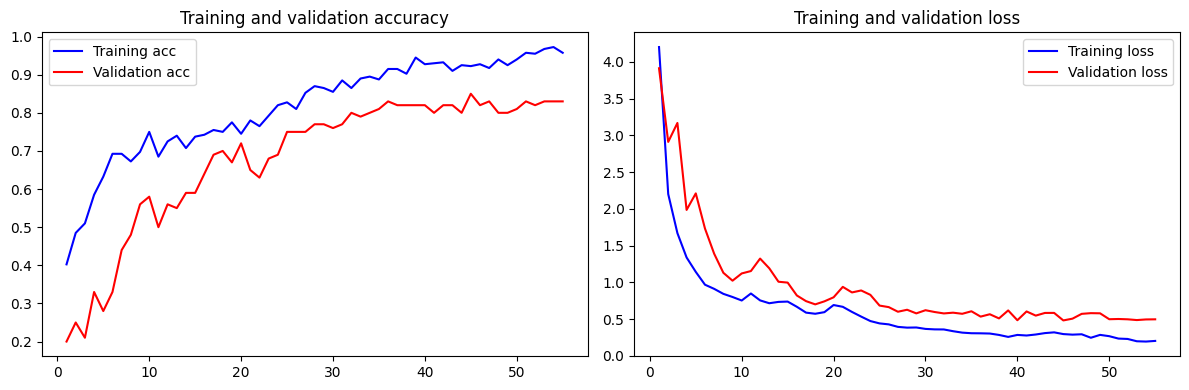

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       0.65      0.75      0.70        20
           2       0.85      0.55      0.67        20
           3       1.00      0.95      0.97        20
           4       0.87      1.00      0.93        20

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.84       100
weighted avg       0.86      0.85      0.84       100



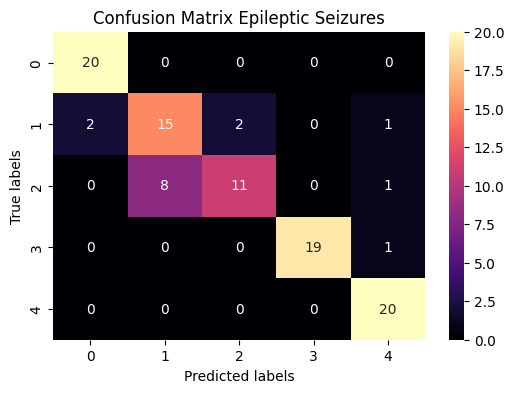

   seed  Timestep     Acc  Val_acc      Loss  Val_loss
0   0.0     128.0  0.9500     0.80  0.264791  0.759872
1   1.0     128.0  0.8600     0.78  0.335779  0.544126
2   2.0     128.0  0.9775     0.90  0.165469  0.350535
3   3.0     128.0  0.9750     0.87  0.196024  0.489134
4   4.0     128.0  0.9575     0.83  0.202246  0.496174


In [ ]:
import pandas as pd

def main():
    '''The class run for 5 seeds - this parameter is set in the LSTM.py file'''
    path = '/content/all_data_epileptic_seizures.csv'
    Time_df = pd.DataFrame(columns=['seed', 'Timestep', 'Acc', 'Val_acc', 'Loss', 'Val_loss'])


    for seed in range(5):
        classifier = EpilepsyClassifier(path, seed=seed)  # Create an instance of EpilepsyClassifier
        Time_df = pd.concat([Time_df, classifier.return_results()], ignore_index=True)

    # The line below was causing the error. It was trying to access 'df_', which wasn't defined.
    # Time_df = pd.concat([Time_df, df_.return_results()], ignore_index=True)
    # The loop above already concatenates the results from the classifier instances into Time_df.
    # So, the problematic line is removed.

    print(Time_df)
    Time_df.to_csv('TimeStepDF_.csv')

if __name__ == "__main__":
    main()